# Tutorial 2: Advanced Usage -- Customized Isochrones and Better HRD

In this tutorial notebook, I will demonstrate how this code handles the isochrone grid and how you could set up your own isochrones.

## Isochrone Matrix

In `ysoisochrone`, we use `matrix` from `numpy` to handle the isochrone data. They are stored by default in the folder called `./isochrone_data/xxx_matrix.mat'`. If you have already gone through the first two tutorials successfully, the code should already have downloaded and formated the isochrone data for both `Baraffe2015` and `Feiden2016` pre-main-sequence stellar evolutionary tracks. You can find the files there under the folder `isochrone_data` (the two files are named `'Baraffe_AgeMassGrid_YSO_matrix.mat'` and `'Feiden_AgeMassGrid_YSO_matrix'`). By default where you are running the code (or this notebook).

The `.mat` files can be read directly into the `Isocrhone` class by using the `customize` option, and lets take the Baraffe track as an example:

In [2]:
import ysoisochrone

isochrone = ysoisochrone.isochrone.Isochrone()
mat_file_dir = './isochrones_data/Baraffe_AgeMassGrid_YSO_matrix.mat'

isochrone.set_tracks('customize', load_file=mat_file_dir)

1

Then we can plot this track that I read in 

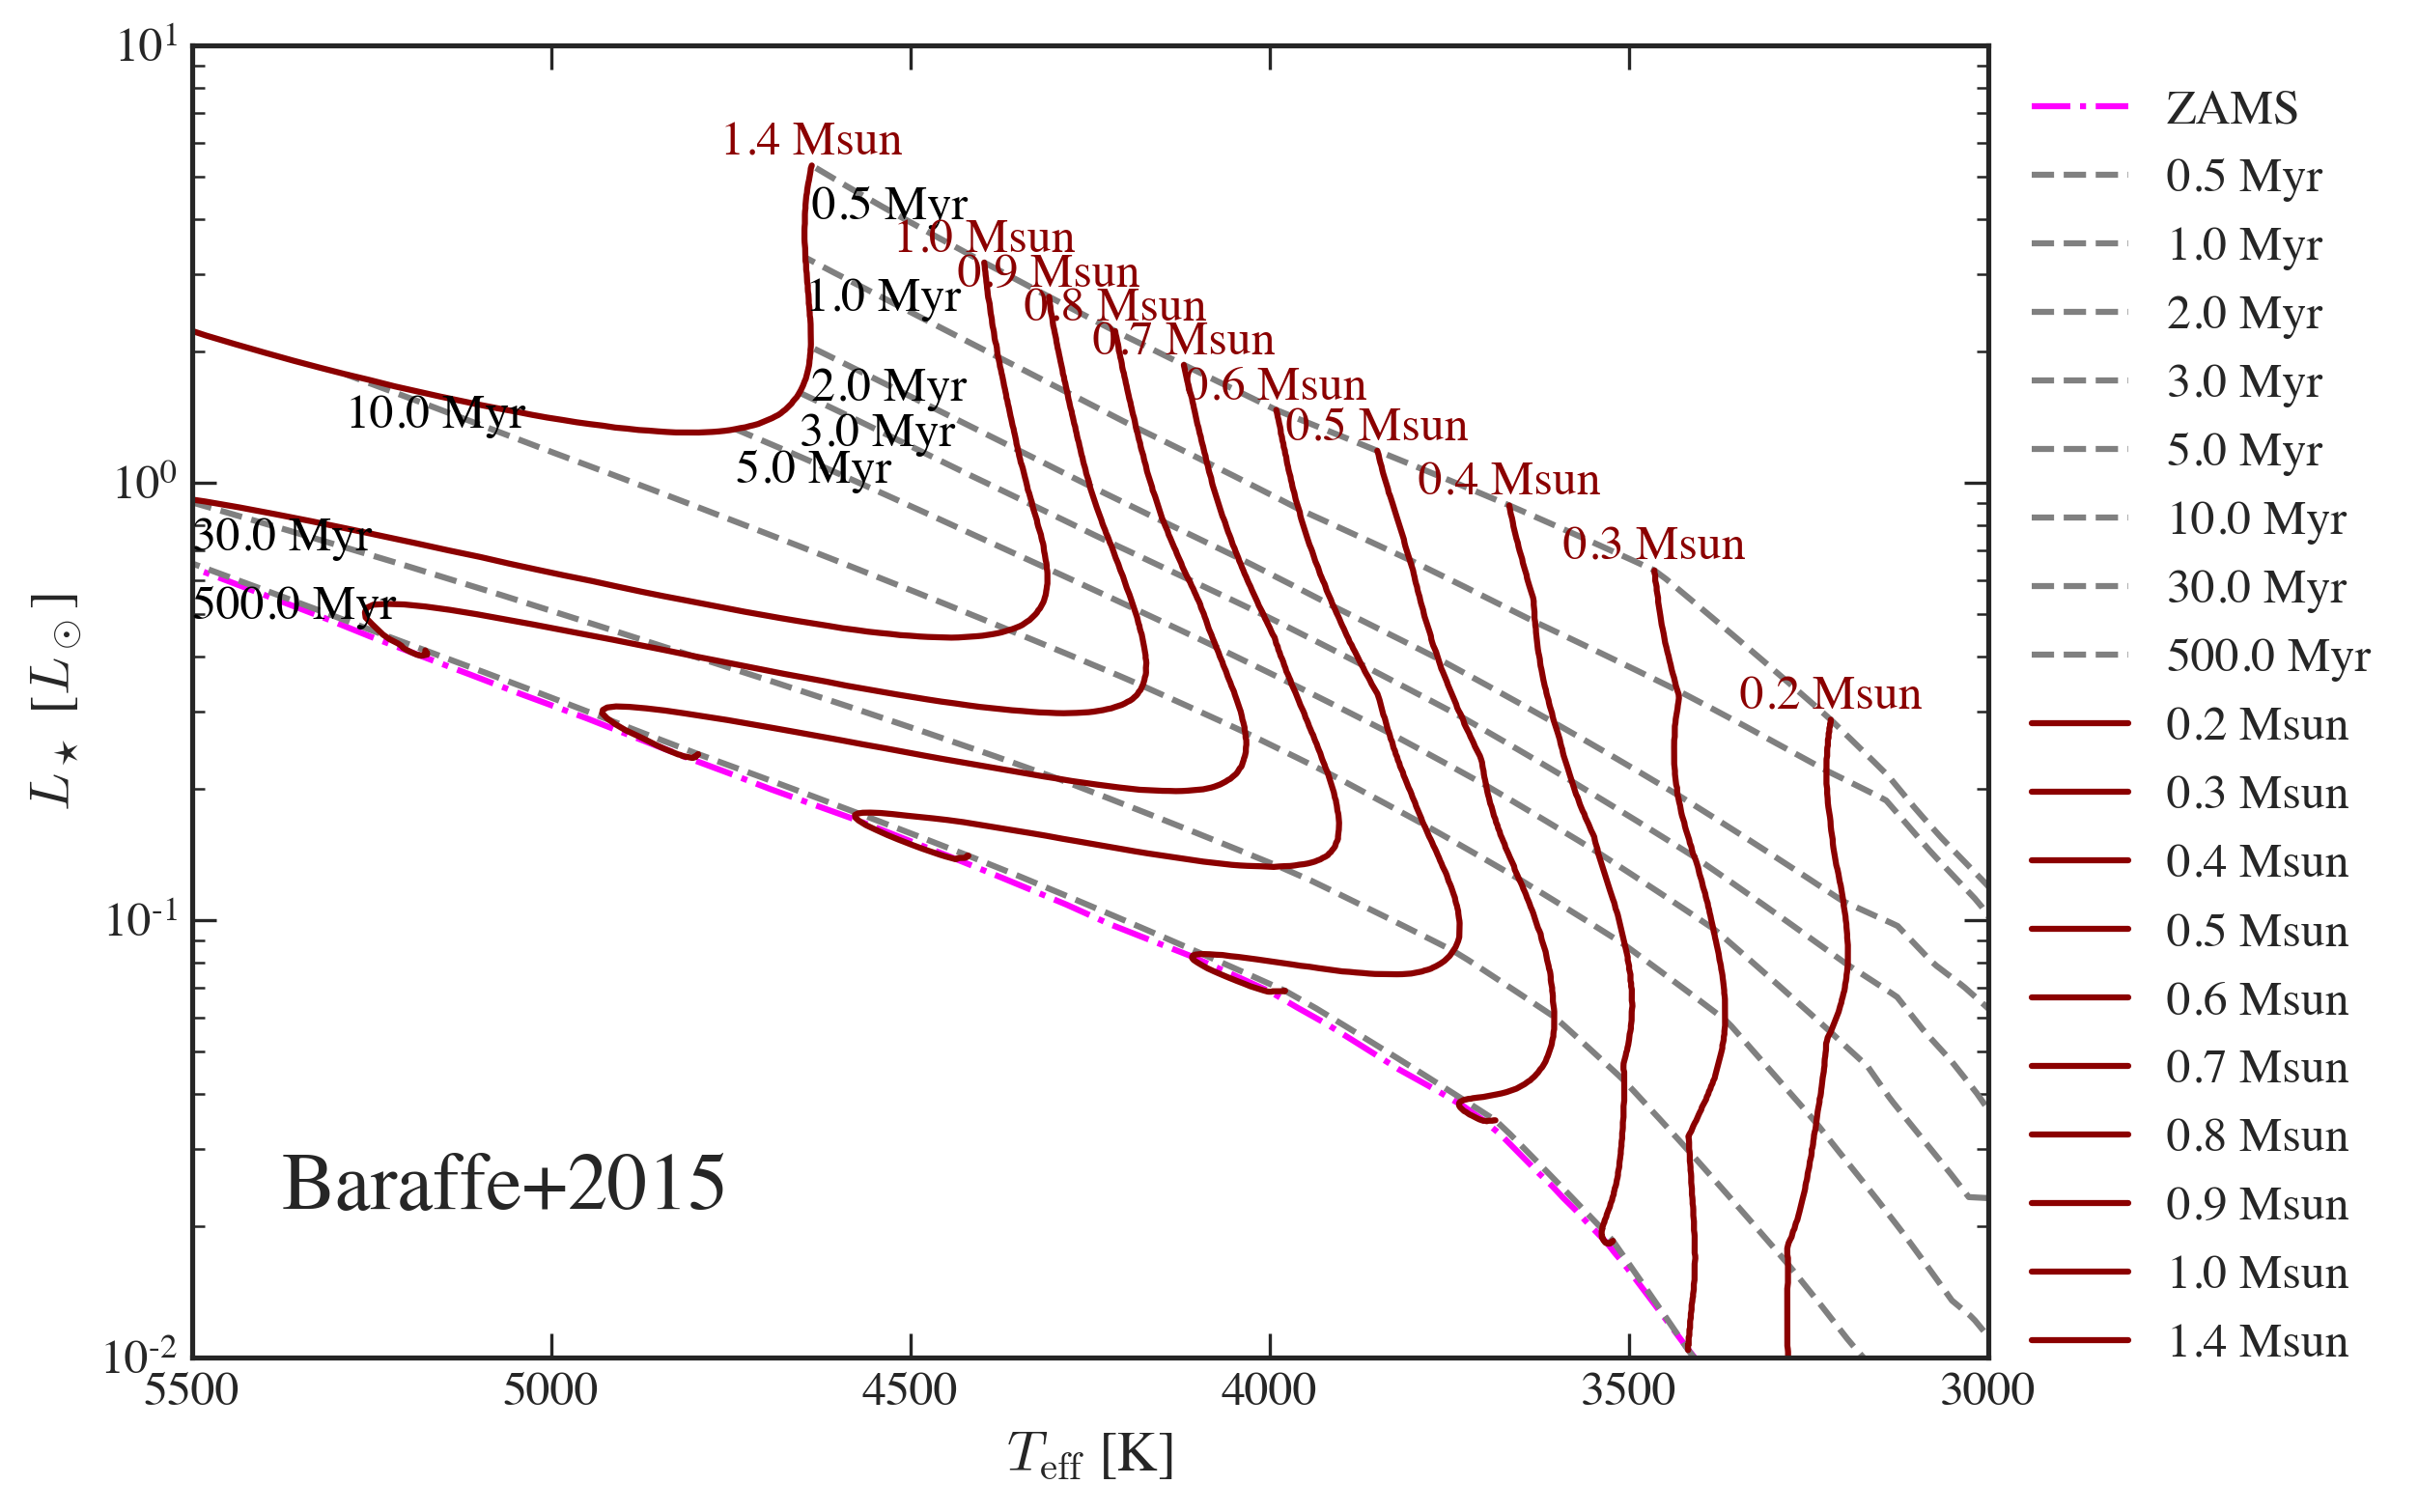

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))

ysoisochrone.plotting.plot_hr_diagram(isochrone, ax_set=ax, 
                                      ages_to_plot=[0.5e6, 1.0e6, 2.0e6, 3.0e6, 5.0e6, 10.0e6, 30.0e6, 500.0e6], 
                                      masses_to_plot=[0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.39],
                                      xlim_set=[5500, 3000], ylim_set=[0.01, 10.0])

ax.annotate('Baraffe+2015', xy=(0.05, 0.1), xycoords='axes fraction', ha='left', va='bottom', fontsize=20)

plt.show()

The `Isochrone` class has three `Attributes`:

- `isochrone.log_age` as the grid for the `log10(age)` in the unit of `yr`. You can think this as the x-axis.
- `isochrone.masses` as the grid for the `masses` in the unit of `solar masses`. You can think this as the y-axis.
- `isochrone.logtlogl` as a 2D grid for `log10(Teff)` in the unit of `K` and `log10(Luminosity)` in the unit of `solar luminosity`.

So to have a 2D grid for teff and luminosity, you can use

In [4]:
# Convert isochrone logtlogl data to Teff and L/Lo
teff_iso = 10**isochrone.logtlogl[:, :, 0]  # Teff
lum_iso = 10**isochrone.logtlogl[:, :, 1]   # L/Lo

Then the first term is for age, and second term is for mass. So to get the constant age lines or mass lines, you can use:

In [5]:
import numpy as np

age = 1.5e6
idx_age = np.nanargmin(np.abs(isochrone.log_age - age))  # Find closest age
teff_thisage = teff_iso[idx_age, :]
lum_thisage = lum_iso[idx_age, :]

mass = 1.0
idx_mass = np.nanargmin(np.abs(isochrone.masses - mass))  # Find closest mass
teff_thismass = teff_iso[:, idx_mass]
lum_thismass = lum_iso[:, idx_mass]

## Make your own isochrone matrix

The read in `.mat` file (such as `Baraffe_AgeMassGrid_YSO_matrix.mat`) also has these three components (`log_age, masses, logtlogl`), and they are basically the same thing as stored in the file `.mat` by `numpy`.

We utilized `meshgrid` to create the grid from the original data. For example, to prepare the `Baraffe` grid. (all the code below is wrapped up in `isochrone.load_baraffe2015_tracks`, and `isochrone.prepare_baraffe_tracks`)

### (i) First we download the original file from their website

'BHAC15_tracks+structure' should have already been downloaded to `./isochrones_data/Baraffe2015/`

### (ii) Then, read in the file. 

Because the data formats are different for different stellar evolutionary models. So you might need to figure our by yourself on how to read them. But here we parepared a few functions in the ysoisochrone.utils for some of them, including
```
read_baraffe_file; read_feiden_trk_file; read_parsec_v1p2_dat_file; read_parsec_v2p0_tab_file 
``` 
and so on.

so for the Baraffe tracks, we can use

In [6]:
import os

# define the data dir
isochrones_data_dir = os.path.join(os.getcwd(), 'isochrones_data')
input_file = os.path.join(isochrones_data_dir, 'Baraffe2015', 'BHAC15_tracks+structure')

# Read the original BHAC15 tracks file
data_points = ysoisochrone.utils.read_baraffe_file(input_file)

The `data_points` are a long array of `[mass, log_age, teff, log_luminosity]` data points. They are the original points provided by different stellar evolutionary models. 

**NOTE** In short, to use your customized isochrones, the only work for you is to create this formated `data_points` array. After this, `ysoisochrone` will have the functions to do all of remaining work.

### (iii) Create meshgrid and save
Then we utilize `meshgrid` to sample the original data points to have a formmated grid.

In [7]:
# Create meshgrid and interpolate the data onto the grid
masses_i, log_age_i, logtlogl_grid, masses_grid, log_age_grid = ysoisochrone.utils.create_meshgrid(data_points)

# Save the parsed data to a .mat file
output_mat_file = os.path.join(isochrones_data_dir, 'Your_matrix_Baraffe_AgeMassGrid_YSO_matrix.mat')

ysoisochrone.utils.save_as_mat(masses_i, log_age_i, logtlogl_grid, output_mat_file)
print(f"File saved as: {output_mat_file}")

Data saved to /Users/dingshandeng/github/ysoisochrone/tests/isochrones_data/Your_matrix_Baraffe_AgeMassGrid_YSO_matrix.mat
File saved as: /Users/dingshandeng/github/ysoisochrone/tests/isochrones_data/Your_matrix_Baraffe_AgeMassGrid_YSO_matrix.mat


Here the `masses_i, log_age_i, logtlogl_grid` are the three variables to be saved and they are the three `attributes` for `Isochrone` class. The `masses_grid, log_age_grid` are the 2D grid points for `mass` and `log_age`. They could be useful to check the read in and outputs.

There are also a few options you could use in the `create_meshgrid`, such as change the range for age: `min_age` (default 0.5 Myrs), `max_age` (default 1000 Myrs); range for mass: `min_mass` (default 0.0 Msun), `max_mass` (default 7.5 Msun); as well as the `interpolation_method` (default is `linear`).

**NOTE** in the future version, we will add the feature of finding the curve of zero-age-main-sequence from the track, so the grid point beyond that will be removed.

Then, to use this customized track to derive age and masses, you can call

  0%|          | 0/1 [00:00<?, ?it/s]/Users/dingshandeng/github/ysoisochrone/ysoisochrone/plotting.py:116: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cb = plt.colorbar(im)


Working on: Sz65
Adopted the customize track from /Users/dingshandeng/github/ysoisochrone/tests/isochrones_data/Your_matrix_Baraffe_AgeMassGrid_YSO_matrix.mat.
sum of Lmass 99.99906842584193
the last index of Lmass 4.9769936527729e-100
sum of Lmass array 30.08980137035469
the last index of Lmass array 0.9999999999999997
check the sum of confidence interval (default 0.68)
0.6865069225384587


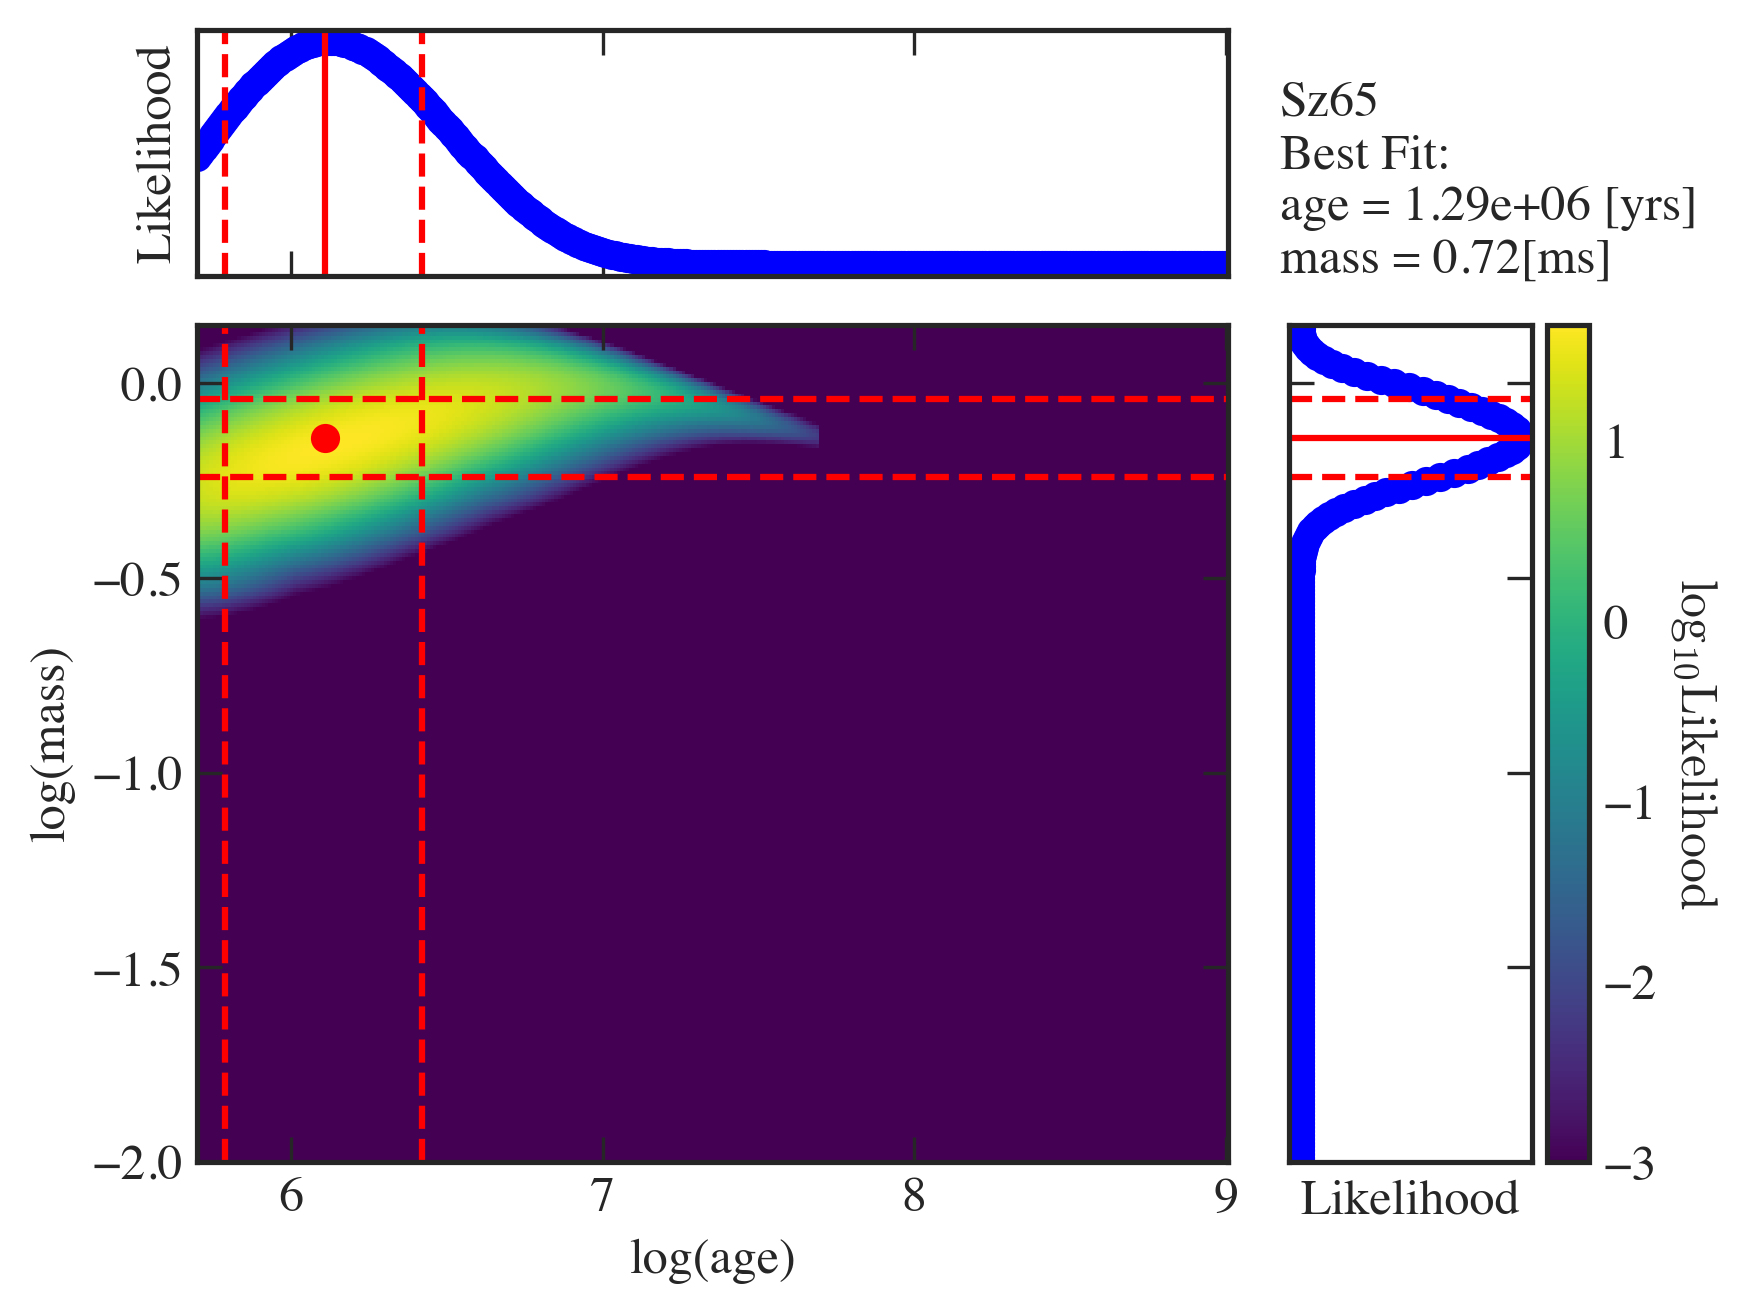

100%|██████████| 1/1 [00:00<00:00,  2.44it/s]

Results for target: Sz65
Best Mass: 0.72 [Msun], Age: 1.29e+06 [yrs]


In [8]:
import pandas as pd

df_prop = pd.read_csv('example_targets.csv')

df_prop_t = df_prop.loc[:0]

best_logmass_output_t, best_logage_output_t, _, _ =\
    ysoisochrone.bayesian.derive_stellar_mass_age(df_prop_t, model='customize', plot=True, 
                                                  isochrone_mat_file=output_mat_file, verbose=True)